In [2]:
import csv 
import sklearn
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from numpy import mean, std, absolute
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.svm import SVR
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor 


In [3]:
df= pd.read_excel('RealEstateDataset.xlsx', sheet_name ='Data', usecols = 'B:H')

C:\Users\Asus\anaconda3\envs\mle_tf\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [4]:
# preprocessing
df = df.rename(columns={"X1 transaction date":"trans_date","X2 house age":"house_age", "X3 distance to the nearest MRT station":"mrt_distance","X4 number of convenience stores":"no_convenience_stores", "X5 latitude" : "latitude" , "X6 longitude":"longitude", "Y house price of unit area" : "house_price_PA" })
df.dropna()

X = df.drop('trans_date', axis = 1)
X = df.iloc[:,:-1]
y  = df.iloc[:, -1]

#Feature normalisation (Linear Regression and Multi-layer Perceptron Neural Network)
sc = StandardScaler()
scaled_X = sc.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(scaled_X,y, test_size = 0.2, random_state = 42)

#Feature normalisation (Support Vector Machine Regression and Decision Tree Regression)
y = y.values.reshape(414,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train = sc.fit_transform(X_train)
X_test= sc.fit_transform(X_test)

Linear Regression

In [14]:
# Linear regression model 
LR = LinearRegression()
# fitting the training data
LR.fit(x_train,y_train)

# 5 fold 
n_folds = 5
lr= LinearRegression()
cv_error = np.average(cross_val_score(lr, scaled_X, y,scoring='neg_mean_squared_error', cv=n_folds))
print('The {}-fold cross-validation mean squared error for this regression model is {:.3f}'.format(n_folds, abs(cv_error)))

The 5-fold cross-validation mean squared error for this regression model is 78.332


Support Vector Machine

In [13]:
#Support Vector Machine Regression Model
pre_svr_model = SVR(kernel='rbf',gamma='scale')
pre_svr_model.fit(X_train,np.ravel(Y_train))
pre_svr_model_pred = pre_svr_model.predict(X_test)

print('Mean Squared Error before parameter tuning {:.3f}'.format(MSE(Y_test,pre_svr_model_pred)))

Mean Squared Error before parameter tuning 67.221


In [ ]:
sns.distplot(Y_test-pre_svr_model_pred)

In [ ]:
plt.scatter(Y_test,pre_svr_model_pred)
plt.plot(pre_svr_model_pred, pre_svr_model.predict(X_test),color = 'red')

In [ ]:
#Parameter tuning for support vector machine
SVR_param_grid = {'C':[0.01, 0.1, 1,10],'kernel':['linear','rbf'],'gamma':[0.001,0.01,0.1,1,10], 'epsilon':[0.01,0.1,1,10]}

In [ ]:
#Find the best parameters
svr_cv = KFold(n_splits = 5)
svr_grid = GridSearchCV(SVR(), SVR_param_grid, cv=svr_cv, scoring='neg_mean_squared_error')
svr_grid.fit(X_train, np.ravel(Y_train))

#Summarize results
print("Best params for SVR: ", svr_grid.best_params_)
print("Best score for SVR: ", absolute(svr_grid.best_score_))

In [8]:
# After getting the best parameters 
post_svr_model = SVR(C=10,epsilon = 1, gamma = 0.1, kernel = 'rbf')
post_svr_model.fit(X_train, np.ravel(Y_train))
post_svr_pred = post_svr_model.predict(X_test)
print('Mean Squared Error after parameter tuning: {:.3f}' .format(MSE(Y_test, post_svr_pred)))

Mean Squared Error after parameter tuning: 41.192


In [ ]:
plt.scatter(Y_test,post_svr_pred)
plt.plot(post_svr_pred, post_svr_model.predict(X_test), color = 'green')

Decision Tree

In [15]:
# Decision Tree Regression Model
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
pre_tree_model = DecisionTreeRegressor()
pre_tree_model.fit(X_train, Y_train)
pre_tree_pred = pre_tree_model.predict(X_test)
print('Mean Squared Error before parameter tuning {:.3f}'.format(MSE(Y_test,pre_tree_pred)))

Mean Squared Error before parameter tuning 72.460


C:\Users\Asus\anaconda3\envs\mle_tf\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


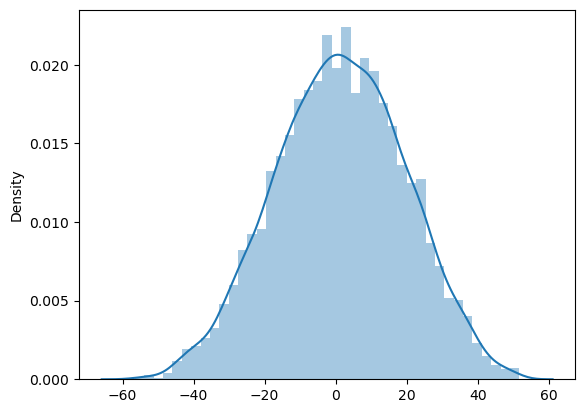

In [10]:
sns.distplot(Y_test-pre_tree_pred)

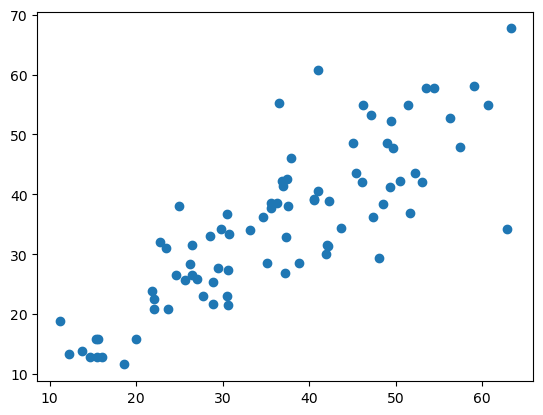

In [11]:
plt.scatter(Y_test,pre_tree_pred)

In [12]:
#Parameter tuning for decision tree

param = {
    'splitter': ['best','random'],
    'max_depth': [1,3,5,7,9,11,12],
    'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10],
    'min_weight_fraction_leaf':[0.1,0.2,0.3,0.4,0.5],
    'max_features':["auto","log2","sqrt",None],
    'max_leaf_nodes':[None,10,20,30,40,50,60,70,80,90]
        }

#define grid search
tree_grid = GridSearchCV(pre_tree_model, param_grid = param, cv = 5,n_jobs = -1, verbose = 3, scoring = 'neg_mean_squared_error' )
tree_grid.fit(X_train,Y_train)

#Summarize Results
print('Decision Tree best Params:', tree_grid.best_params_)
print('Decision Tree best Score:', absolute(tree_grid.best_score_))

Fitting 5 folds for each of 28000 candidates, totalling 140000 fits
Decision Tree best Params: {'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}
Decision Tree best Score: -73.84556006495349


In [16]:
# After getting the best parameters
DTreg = DecisionTreeRegressor(criterion = 'squared_error',max_depth = 3, min_samples_leaf = 1,max_features = 'auto',max_leaf_nodes = 50, min_weight_fraction_leaf = 0.1, splitter = 'best')
DTreg.fit(X_train,Y_train)
post_tree_pred = DTreg.predict(X_test)
print('mean_squared_error : {:.3f} '.format(MSE(Y_test,post_tree_pred)))

mean_squared_error : 43.880 


In [ ]:
plt.scatter(Y_test,post_tree_pred)

Perceptron Neural Network

In [10]:
#Perceptron Neural Network
#Parameter Tuning for Multi-layer Perceptron Neural Network

param= {
    'neuron_hidden_layer_1': [6,7],
    'neuron_hidden_layer_2': [3,4, 5],
}

def createNN( neuron_hidden_layer_1 , neuron_hidden_layer_2 ):
    
    model = Sequential()
    if neuron_hidden_layer_1 > neuron_hidden_layer_2:
        model.add(Dense(units = neuron_hidden_layer_1, activation = 'relu', kernel_initializer = 'he_normal', input_shape = (scaled_X.shape[1],)))
        model.add(Dense(units =neuron_hidden_layer_2, activation = 'relu', kernel_initializer = 'he_normal'))
        model.add(Dense(1))

        model.compile(optimizer = 'adam' , loss = 'mse' , metrics= ['mse'])

        return model

#Define Grid Search
model_wrapper = KerasRegressor(build_fn = createNN, batch_size= 30, epochs = 200)
grid_search = GridSearchCV(model_wrapper, n_jobs=-1, cv=5, param_grid = param, scoring ='neg_mean_squared_error')
grid_search.fit(x_train, y_train)



C:\Users\Asus\anaconda3\envs\mle_tf\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Asus\anaconda3\envs\mle_tf\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Asus\anaconda3\envs\mle_tf\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 159, in fit
    if (losses.is_categorical_crossentropy(self.model.loss) and
AttributeError: 'NoneType' object has no attribute 'loss'

  warnings.warn(some_fits_failed_mess

Epoch 1/200
331/331 [==============================] - 0s 247us/sample - loss: 1805.9702 - mean_squared_error: 1805.9702
Epoch 2/200
331/331 [==============================] - 0s 52us/sample - loss: 1790.3954 - mean_squared_error: 1790.3954
Epoch 3/200
331/331 [==============================] - 0s 44us/sample - loss: 1775.7009 - mean_squared_error: 1775.7009
Epoch 4/200
331/331 [==============================] - 0s 36us/sample - loss: 1762.9057 - mean_squared_error: 1762.9054
Epoch 5/200
331/331 [==============================] - 0s 50us/sample - loss: 1750.6324 - mean_squared_error: 1750.6326
Epoch 6/200
331/331 [==============================] - 0s 47us/sample - loss: 1739.2736 - mean_squared_error: 1739.2738
Epoch 7/200
331/331 [==============================] - 0s 49us/sample - loss: 1729.0225 - mean_squared_error: 1729.0225
Epoch 8/200
331/331 [==============================] - 0s 39us/sample - loss: 1719.7308 - mean_squared_error: 1719.7307
Epoch 9/200
331/331 [==================

331/331 [==============================] - 0s 47us/sample - loss: 477.5465 - mean_squared_error: 477.5465
Epoch 70/200
331/331 [==============================] - 0s 56us/sample - loss: 452.6640 - mean_squared_error: 452.6640
Epoch 71/200
331/331 [==============================] - 0s 43us/sample - loss: 429.2124 - mean_squared_error: 429.2124
Epoch 72/200
331/331 [==============================] - 0s 76us/sample - loss: 406.7920 - mean_squared_error: 406.7920
Epoch 73/200
331/331 [==============================] - 0s 67us/sample - loss: 385.9398 - mean_squared_error: 385.9398
Epoch 74/200
331/331 [==============================] - 0s 66us/sample - loss: 365.7140 - mean_squared_error: 365.7140
Epoch 75/200
331/331 [==============================] - 0s 53us/sample - loss: 347.0115 - mean_squared_error: 347.0116
Epoch 76/200
331/331 [==============================] - 0s 68us/sample - loss: 330.0108 - mean_squared_error: 330.0107
Epoch 77/200
331/331 [==============================] - 0s 72

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001BE8798AB08>,
             n_jobs=-1,
             param_grid={'neuron_hidden_layer_1': [5, 6, 7],
                         'neuron_hidden_layer_2': [2, 3, 4, 5]},
             scoring='neg_mean_squared_error')

In [11]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_neuron_hidden_layer_1,param_neuron_hidden_layer_2,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.831661,0.458719,0.130123,0.008548,5,2,"{'neuron_hidden_layer_1': 5, 'neuron_hidden_la...",-91.675196,-83.442387,-71.534818,-56.561908,-152.274921,-91.097846,32.793344,8
1,5.630406,0.690460,0.156421,0.014534,5,3,"{'neuron_hidden_layer_1': 5, 'neuron_hidden_la...",-71.639876,-93.896000,-63.033183,-108.330449,-137.525853,-94.885072,26.664113,10
2,5.268928,0.115779,0.153996,0.004724,5,4,"{'neuron_hidden_layer_1': 5, 'neuron_hidden_la...",-70.227250,-79.856283,-80.260501,-64.335232,-151.600851,-89.256023,31.746786,6
3,0.000904,0.000494,0.000000,0.000000,5,5,"{'neuron_hidden_layer_1': 5, 'neuron_hidden_la...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
4,5.104713,0.072754,0.156449,0.001544,6,2,"{'neuron_hidden_layer_1': 6, 'neuron_hidden_la...",-61.952153,-86.599543,-68.012073,-96.550494,-112.593274,-85.141507,18.531347,3
5,5.464538,0.390196,0.159523,0.022466,6,3,"{'neuron_hidden_layer_1': 6, 'neuron_hidden_la...",-70.567014,-77.732816,-61.191302,-57.609641,-134.187481,-80.257651,27.875322,1
6,6.428848,0.154658,0.182941,0.003650,6,4,"{'neuron_hidden_layer_1': 6, 'neuron_hidden_la...",-68.718908,-69.743638,-72.077195,-79.872952,-133.973398,-84.877218,24.857330,2
7,5.696893,0.139940,0.173848,0.018760,6,5,"{'neuron_hidden_layer_1': 6, 'neuron_hidden_la...",-66.350129,-77.599760,-61.041552,-72.494382,-149.904111,-85.477987,32.693670,4
8,5.930898,0.610620,0.208968,0.007604,7,2,"{'neuron_hidden_layer_1': 7, 'neuron_hidden_la...",-67.385927,-99.974248,-63.695949,-89.656187,-138.184417,-91.779346,26.865632,9
9,6.739402,1.172384,0.208142,0.015428,7,3,"{'neuron_hidden_layer_1': 7, 'neuron_hidden_la...",-62.452845,-68.230056,-68.684600,-80.607825,-147.433647,-85.481795,31.533754,5


In [12]:
#Summarize Results of model with best parameter and its score 
print('Multi-layer Perceptron Neural Network best Params:', grid_search.best_params_)
print('Multi-layer Perceptron Neural Network best Score:', grid_search.best_score_)

Multi-layer Perceptron Neural Network best Params: {'neuron_hidden_layer_1': 6, 'neuron_hidden_layer_2': 3}
Multi-layer Perceptron Neural Network best Score: -80.25765072978587
